In [1]:
import pandas as pd
import os
from constants import TASK_MODEL_PATH, TOKENIZER_SUFFIXES, MOLNET_DIRECTORY, PROJECT_PATH, REACTION_PREDICTION_DIRECTORY, DESCRIPTORS

from glob import glob
from pathlib import Path
pd.set_option('display.max_rows', 500)

classification_scores = []
regression_scores = []
TOKENIZER_SUFFIXES+=["smiles_isomers_atom","smiles_isomers_sentencepiece","selfies_isomers_atom","selfies_isomers_sentencepiece"]
for tokenizer_suffix in TOKENIZER_SUFFIXES:
    for task in MOLNET_DIRECTORY.keys():
        task_tokenizer_path = TASK_MODEL_PATH/task/tokenizer_suffix
        if task.startswith("bace") and not ("isomer" in tokenizer_suffix) :
            task_tokenizer_path = Path("/data/jgut/SoS_models/task")/task/tokenizer_suffix
        print(task_tokenizer_path)
        if task_tokenizer_path.exists():
            for hyperparameter_path in glob(str(task_tokenizer_path) + "/*", recursive=True):
                scores_path = hyperparameter_path+"/scores.csv"
                print(scores_path)
                if not Path(scores_path).is_file():
                    continue
                new_score_df = pd.read_csv(scores_path)
                if list(new_score_df.task_type)[0] == "classification":
                    classification_scores.append(new_score_df)
                else:
                    regression_scores.append(new_score_df)

regression_scores = pd.concat(regression_scores, axis = 0, sort = False)
classification_scores = pd.concat(classification_scores, axis = 0, sort = False)

/home/jgut/miniconda3/envs/SoS3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/jgut/miniconda3/envs/SoS3/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


/data/jgut/SoS_models/task/bace_classification/selfies_atom
/data/jgut/SoS_models/task/bace_classification/selfies_atom/5e-06_0.1_based_norm/scores.csv
/data/jgut/SoS_models/task/bace_classification/selfies_atom/5e-06_0.3_based_norm/scores.csv
/data/jgut/SoS_models/task/bace_classification/selfies_atom/5e-05_0.1_based_norm/scores.csv
/data/jgut/SoS_models/task/bace_classification/selfies_atom/5e-05_0.3_based_norm/scores.csv
/data/jgut/SoS_models/task/bace_classification/selfies_atom/1e-05_0.1_based_norm/scores.csv
/data/jgut/SoS_models/task/bace_classification/selfies_atom/1e-05_0.3_based_norm/scores.csv
/data/jgut/SoS_models/task/bace_classification/selfies_atom/train.label/scores.csv
/data/jgut/SoS_models/task/bace_classification/selfies_atom/5e-05_0.2_based_norm/scores.csv
/data/jgut/SoS_models/task/bace_classification/selfies_atom/input0/scores.csv
/data/jgut/SoS_models/task/bace_classification/selfies_atom/label/scores.csv
/data/jgut/SoS_models/task/bace_classification/selfies_ato

/data/jgut/SoS_models/hiv/smiles_sentencepiece/5e-06_0.2_based_norm/scores.csv
/data/jgut/SoS_models/lipo/smiles_sentencepiece
/data/jgut/SoS_models/lipo/smiles_sentencepiece/5e-06_0.1_based_norm/scores.csv
/data/jgut/SoS_models/lipo/smiles_sentencepiece/5e-06_0.3_based_norm/scores.csv
/data/jgut/SoS_models/lipo/smiles_sentencepiece/5e-05_0.1_based_norm/scores.csv
/data/jgut/SoS_models/lipo/smiles_sentencepiece/5e-05_0.3_based_norm/scores.csv
/data/jgut/SoS_models/lipo/smiles_sentencepiece/1e-05_0.1_based_norm/scores.csv
/data/jgut/SoS_models/lipo/smiles_sentencepiece/1e-05_0.3_based_norm/scores.csv
/data/jgut/SoS_models/lipo/smiles_sentencepiece/5e-05_0.2_based_norm/scores.csv
/data/jgut/SoS_models/lipo/smiles_sentencepiece/1e-05_0.2_based_norm/scores.csv
/data/jgut/SoS_models/lipo/smiles_sentencepiece/5e-06_0.2_based_norm/scores.csv
/data/jgut/SoS_models/tox21/smiles_sentencepiece
/data/jgut/SoS_models/tox21/smiles_sentencepiece/5e-06_0.1_based_norm/scores.csv
/data/jgut/SoS_models/t

/data/jgut/SoS_models/bace_classification/smiles_isomers_atom/5e-06_0.1_based_norm/scores.csv
/data/jgut/SoS_models/bace_classification/smiles_isomers_atom/5e-06_0.3_based_norm/scores.csv
/data/jgut/SoS_models/bace_classification/smiles_isomers_atom/5e-05_0.1_based_norm/scores.csv
/data/jgut/SoS_models/bace_classification/smiles_isomers_atom/5e-05_0.3_based_norm/scores.csv
/data/jgut/SoS_models/bace_classification/smiles_isomers_atom/1e-05_0.1_based_norm/scores.csv
/data/jgut/SoS_models/bace_classification/smiles_isomers_atom/1e-05_0.3_based_norm/scores.csv
/data/jgut/SoS_models/bace_classification/smiles_isomers_atom/5e-05_0.2_based_norm/scores.csv
/data/jgut/SoS_models/bace_classification/smiles_isomers_atom/1e-05_0.2_based_norm/scores.csv
/data/jgut/SoS_models/bace_classification/smiles_isomers_atom/5e-06_0.2_based_norm/scores.csv
/data/jgut/SoS_models/bace_regression/smiles_isomers_atom
/data/jgut/SoS_models/bace_regression/smiles_isomers_atom/5e-06_0.1_based_norm/scores.csv
/data/

/data/jgut/SoS_models/hiv/selfies_isomers_atom/5e-05_0.2_based_norm/scores.csv
/data/jgut/SoS_models/hiv/selfies_isomers_atom/1e-05_0.2_based_norm/scores.csv
/data/jgut/SoS_models/hiv/selfies_isomers_atom/5e-06_0.2_based_norm/scores.csv
/data/jgut/SoS_models/lipo/selfies_isomers_atom
/data/jgut/SoS_models/lipo/selfies_isomers_atom/5e-06_0.1_based_norm/scores.csv
/data/jgut/SoS_models/lipo/selfies_isomers_atom/5e-06_0.3_based_norm/scores.csv
/data/jgut/SoS_models/lipo/selfies_isomers_atom/5e-05_0.1_based_norm/scores.csv
/data/jgut/SoS_models/lipo/selfies_isomers_atom/5e-05_0.3_based_norm/scores.csv
/data/jgut/SoS_models/lipo/selfies_isomers_atom/1e-05_0.1_based_norm/scores.csv
/data/jgut/SoS_models/lipo/selfies_isomers_atom/1e-05_0.3_based_norm/scores.csv
/data/jgut/SoS_models/lipo/selfies_isomers_atom/5e-05_0.2_based_norm/scores.csv
/data/jgut/SoS_models/lipo/selfies_isomers_atom/1e-05_0.2_based_norm/scores.csv
/data/jgut/SoS_models/lipo/selfies_isomers_atom/5e-06_0.2_based_norm/scores

In [2]:
columns = list(regression_scores.columns[-3:])
columns.extend(regression_scores.columns[:-3])

regression_scores.sort_values(["task", "tokenizer"])[columns].sort_values(["mean_absolute_error"]).drop(["model_size", "Unnamed: 0", "task_type"], axis="columns").groupby(["task", "tokenizer"]).first()


mean_absolute_error  max_error  \
task            tokenizer                                                       
bace_regression selfies_atom                              0.665644   2.313257   
                selfies_isomers_atom                      0.645083   2.893325   
                selfies_isomers_sentencepiece             0.611286   2.172028   
                selfies_sentencepiece                     1.112284   3.583172   
                smiles_atom                               1.072521   3.018604   
                smiles_isomers_atom                       0.576228   2.750119   
                smiles_isomers_sentencepiece              0.657473   2.928247   
                smiles_sentencepiece                      1.078452   3.000588   
clearance       selfies_atom                              1.019760   2.862548   
                selfies_isomers_atom                      0.872791   3.239782   
                selfies_isomers_sentencepiece             1.054104   3.461823   
                selfies_sentencepiece                     1.076179   3.079184   
                smiles_atom                               0.958213   3.217534   
                smiles_isomers_atom                       0.872958   3.102813   
                smiles_isomers_sentencepiece              1.101552   2.415144   
                smiles_sentencepiece                      1.009197   2.746415   
delaney         selfies_atom                              0.394425   1.533072   
                selfies_isomers_atom                      0.407532   1.961080   
                selfies_isomers_sentencepiece             0.485352   1.756895   
                selfies_sentencepiece                     0.506865   1.417774   
                smiles_atom                               0.360438   1.585986   
                smiles_isomers_atom                       0.359700   1.628031   
                smiles_isomers_sentencepiece              0.502597   2.089880   
                smiles_sentencepiece                      0.580551   2.154503   
lipo            selfies_atom                              0.689535   2.776778   
                selfies_isomers_atom                      0.549668   2.478325   
                selfies_isomers_sentencepiece             0.636758   2.612354   
                selfies_sentencepiece                     0.640858   3.102017   
                smiles_atom                               0.623058   2.433880   
                smiles_isomers_atom                       0.517186   2.647385   
                smiles_isomers_sentencepiece              0.629662   2.882326   
                smiles_sentencepiece                      0.649462   2.050359   

                                               mean_squared_error  \
task            tokenizer                                           
bace_regression selfies_atom                             0.688964   
                selfies_isomers_atom                     0.657136   
                selfies_isomers_sentencepiece            0.566057   
                selfies_sentencepiece                    1.714706   
                smiles_atom                              1.644988   
                smiles_isomers_atom                      0.537215   
                smiles_isomers_sentencepiece             0.667397   
                smiles_sentencepiece                     1.587879   
clearance       selfies_atom                             1.578902   
                selfies_isomers_atom                     1.260572   
                selfies_isomers_sentencepiece            1.747017   
                selfies_sentencepiece                    1.593290   
                smiles_atom                              1.468817   
                smiles_isomers_atom                      1.246937   
                smiles_isomers_sentencepiece             1.533561   
                smiles_sentencepiece                     1.391661   
delaney         selfies_atom                      

In [5]:
from plotting import plot_scores
columns = list(classification_scores.columns[-3:])
columns.extend(classification_scores.columns[:-3])
tasks = classification_scores.task.unique()
tokenizers = classification_scores.tokenizer.unique()
scores = {}
for task in tasks:
    for tokenizer in tokenizers:
        scores[tokenizer] = scores.get(tokenizer, []) + [max(classification_scores[(classification_scores["tokenizer"]==tokenizer)&(classification_scores["task"]== task)]["ROC_AUC"])]
plot_scores(scores, tasks, "AUROC", Path("test/classification_report.svg"))
#classification_scores.sort_values(["task", "tokenizer"])[columns].sort_values(["ROC_AUC"], ascending=False).drop(["model_size", "Unnamed: 0", "task_type"], axis="columns").groupby(["task", "tokenizer"]).first()


In [10]:
from plotting import plot_scores
columns = list(regression_scores.columns[-3:])
columns.extend(regression_scores.columns[:-3])
tasks = regression_scores.task.unique()
tokenizers = regression_scores.tokenizer.unique()
scores = {}
for task in tasks:
    for tokenizer in tokenizers:
        scores[tokenizer] = scores.get(tokenizer, []) + [max(regression_scores[(regression_scores["tokenizer"]==tokenizer)&(regression_scores["task"]== task)]["rectified_mean_squared_error"])]
plot_scores(scores, tasks, "RMSE", Path("test/regression_report.svg"))

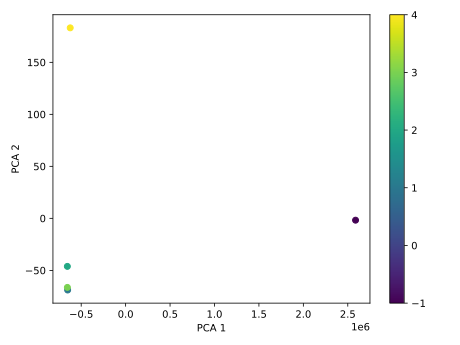

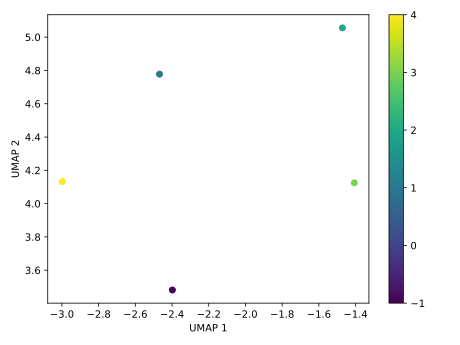

In [16]:
from IPython.display import SVG, display
from pathlib import Path

def show_svg():
    
    display(SVG(Path("test/test_pca.svg")))
    display(SVG(Path("test/test_umap.svg")))
        
show_svg()

In [7]:
max(classification_scores[(classification_scores["tokenizer"]=="smiles_atom")&(classification_scores["task"]== "hiv")]["ROC_AUC"])

0.7039032414126754

In [12]:
import pandas as pd
from constants import REACTION_PREDICTION_DIRECTORY, TOKENIZER_SUFFIXES, PROJECT_PATH
pd.options.display.float_format = '{:,.3f}'.format
dfs = []
for task in ["lef"]:
    for tokenizer in ["selfies_atom", "selfies_sentencepiece", "smiles_sentencepiece"]:
        dfs.append(pd.read_csv(PROJECT_PATH/"reaction_prediction_beam_neu"/task/tokenizer/"output.csv"))
df = pd.concat(dfs)
df["top_perc_0"]=0
df["valid_perc_0"]=0
df["unk_perc_0"]=0
for i in range(1,11):
    df["top_perc_"+str(i)] =df["top_"+str(i)]/df["all_samples"]+df["top_perc_"+str(i-1)]
    df["valid_perc_"+str(i)] =df["valid_"+str(i)]/df["all_samples"]
    df["unk_perc_"+str(i)] =df["unk_"+str(i)]/df["all_samples"]
df.sort_values(["task", "model"])[[i for i in df.columns if (("perc" in i) and ("0" not in i))or i in ["model", "task"]]].to_markdown()

'|    | model                 | task   |   top_perc_1 |   valid_perc_1 |   unk_perc_1 |   top_perc_2 |   valid_perc_2 |   unk_perc_2 |   top_perc_3 |   valid_perc_3 |   unk_perc_3 |   top_perc_4 |   valid_perc_4 |   unk_perc_4 |   top_perc_5 |   valid_perc_5 |   unk_perc_5 |   top_perc_6 |   valid_perc_6 |   unk_perc_6 |   top_perc_7 |   valid_perc_7 |   unk_perc_7 |   top_perc_8 |   valid_perc_8 |   unk_perc_8 |   top_perc_9 |   valid_perc_9 |   unk_perc_9 |\n|---:|:----------------------|:-------|-------------:|---------------:|-------------:|-------------:|---------------:|-------------:|-------------:|---------------:|-------------:|-------------:|---------------:|-------------:|-------------:|---------------:|-------------:|-------------:|---------------:|-------------:|-------------:|---------------:|-------------:|-------------:|---------------:|-------------:|-------------:|---------------:|-------------:|\n|  0 | selfies_atom          | lef    |     0.437228 |       0.983985 |

In [ ]:
descriptors = [ 'NumAliphaticCarbocycles',
 'NumAliphaticHeterocycles',
 'NumAliphaticRings',
 'NumAromaticCarbocycles',
 'NumAromaticHeterocycles',
 'NumAromaticRings',
 'NumHAcceptors',
 'NumHDonors',
 'NumHeteroatoms',
 'NumRotatableBonds',
 'NumSaturatedCarbocycles',
 'NumSaturatedHeterocycles',
 'NumSaturatedRings',
 'RingCount',]
indexes = [str(DESCRIPTORS.index(descriptor)) for descriptor in descriptors]
test = pd.read_csv("processed/10m_deduplicated.csv", skiprows=0, usecols=indexes)
for index, descriptor in enumerate(descriptors):
    amount = sum(test[indexes[index]].gt(0))
    print(f"The stats for descriptor {descriptor}")
    print(f"Amount of mols with trait: {amount}, mols without trait: {len(test)-amount}")
    print(f"This is {amount/len(test):.3f}, mols without trait: {1-amount/len(test):.3f}")

In [ ]:
import pandas as pd
from constants import DESCRIPTORS

descriptors = [
 'NumAliphaticHeterocycles',
 'NumAromaticHeterocycles',
 'NumSaturatedHeterocycles',]
indexes = [str(DESCRIPTORS.index(descriptor)) for descriptor in descriptors]
test = pd.read_csv("processed/10m_deduplicated.csv", skiprows=0, usecols=indexes)

amount = sum((test[indexes[0]]+test[indexes[1]]+test[indexes[2]]).gt(0))
print(f"The stats for descriptor heterocycles")
print(f"Amount of mols with trait: {amount}, mols without trait: {len(test)-amount}")
print(f"This is {amount/len(test):.3f}, mols without trait: {1-amount/len(test):.3f}")